# Data Analysis (qubit_TransmonCross_cap_matrix)

## Configuration

Disable cell scrolling.

Parameters are stored in a shared script.

In [1]:
from parameters import *
os.makedirs('scalers', exist_ok=True)
os.makedirs(f'{DATA_DIR}', exist_ok=True)
os.makedirs(f'{DATA_DIR}/npy', exist_ok=True)

## Library

In [2]:
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from sklearn.preprocessing import MinMaxScaler
import joblib

## Datasets

### Load
From https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/tree/main

In [8]:
df = pd.read_json("qubit-TransmonCross-cap_matrix.json")

### Look at the data and structure

In [9]:
#look at the first value
first_entry = df.iloc[100]

# Print the headers and their corresponding values
for header, value in first_entry.items():
    print(f"{header}: {value}")

sim_results: {'cross_to_ground': 155.21897, 'claw_to_ground': 63.04611, 'cross_to_claw': 1.83606, 'cross_to_cross': 155.21897, 'claw_to_claw': 65.18175, 'ground_to_ground': 279.3005, 'units': 'fF'}
sim_options: {'setup': {'name': 'sweep_setup', 'reuse_selected_design': False, 'reuse_setup': False, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 30, 'min_passes': 2, 'min_converged_passes': 1, 'percent_error': 0.1, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative', 'run': {'name': 'sweep_v2.0', 'components': ['Q'], 'open_terminations': [['Q', 'readout']], 'box_plus_buffer': True}}, 'renderer_options': {'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.2, 'y_buffer_width_mm': 0.2, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 5, 'plot_ansys_fields_options': {'nam

In [10]:
#Look at the headers relevant for us, to start lets only look at the sim_results (our x data) and design (our y data)
sim_results_column = df['sim_results']
print(sim_results_column, '\n\n')

design_column = df['design']
print(design_column)

0       {'cross_to_ground': 158.40783, 'claw_to_ground...
1       {'cross_to_ground': 188.15089, 'claw_to_ground...
2       {'cross_to_ground': 104.3534, 'claw_to_ground'...
3       {'cross_to_ground': 174.13928, 'claw_to_ground...
4       {'cross_to_ground': 120.03923, 'claw_to_ground...
                              ...                        
1929    {'cross_to_ground': 174.4638, 'claw_to_ground'...
1930    {'cross_to_ground': 187.43537, 'claw_to_ground...
1931    {'cross_to_ground': 172.14561, 'claw_to_ground...
1932    {'cross_to_ground': 56.7523, 'claw_to_ground':...
1933    {'cross_to_ground': 62.01, 'claw_to_ground': 5...
Name: sim_results, Length: 1934, dtype: object 


0       {'design_options': {'pos_x': '-1500um', 'pos_y...
1       {'design_options': {'pos_x': '-1500um', 'pos_y...
2       {'design_options': {'pos_x': '-1500um', 'pos_y...
3       {'design_options': {'pos_x': '-1500um', 'pos_y...
4       {'design_options': {'pos_x': '-1500um', 'pos_y...
                      

In [11]:
#take a look at everything in the design dataset
# Flatten the design column
design_flat = json_normalize(df['design'])

# List all column headers
design_column_vals = design_flat.columns.tolist()
print(design_column_vals)
print('length: ',len(design_column_vals))

['design_tool', 'design_options.pos_x', 'design_options.pos_y', 'design_options.orientation', 'design_options.chip', 'design_options.layer', 'design_options.connection_pads.readout.connector_type', 'design_options.connection_pads.readout.claw_length', 'design_options.connection_pads.readout.ground_spacing', 'design_options.connection_pads.readout.claw_width', 'design_options.connection_pads.readout.claw_gap', 'design_options.connection_pads.readout.claw_cpw_length', 'design_options.connection_pads.readout.claw_cpw_width', 'design_options.connection_pads.readout.connector_location', 'design_options.cross_width', 'design_options.cross_length', 'design_options.cross_gap', 'design_options.hfss_inductance', 'design_options.hfss_capacitance', 'design_options.hfss_resistance', 'design_options.hfss_mesh_kw_jj', 'design_options.q3d_inductance', 'design_options.q3d_capacitance', 'design_options.q3d_resistance', 'design_options.q3d_mesh_kw_jj', 'design_options.gds_cell_name', 'design_options.aedt

### Reformat

In [12]:
#flatten what will be our X data
X = json_normalize(df['sim_results'])
# Dropping the 'units' column for now because they are al in fF and this info isnt useful
X = X.drop(columns=['units'])
print(X)

      cross_to_ground  claw_to_ground  cross_to_claw  cross_to_cross  \
0           158.40783        90.86585        3.73363       158.40783   
1           188.15089        79.19378        2.93820       188.15089   
2           104.35340        80.18130        3.16131       104.35340   
3           174.13928        97.22405        5.77590       174.13928   
4           120.03923        65.68607        2.87375       120.03923   
...               ...             ...            ...             ...   
1929        174.46380       101.53197        4.45645       174.46380   
1930        187.43537       112.62570        7.95178       187.43537   
1931        172.14561       136.36810        7.65968       172.14561   
1932         56.75230        65.78116        2.48795        56.75230   
1933         62.01000        55.50796        2.54396        62.01000   

      claw_to_claw  ground_to_ground  
0         94.97421         311.25590  
1         82.44280         333.52997  
2         83.76412

In [13]:
#flatten what will be our y data
y = json_normalize(df['design'])

#get rid of this column because there are two spellings in the dataset that will confuse the NN. We always just use Qiskit, so for now we dont need this
y = y.drop(columns=['design_tool']) 

#output of processing later on when I dont drop this column:
'''
One-hot encoding for 'design_tool':
      design_tool_Qiskit Metal  design_tool_qiskit-metal
 0                          0.0                       1.0 
'''

print(y)

     design_options.pos_x design_options.pos_y design_options.orientation  \
0                 -1500um               1200um                        -90   
1                 -1500um               1200um                        -90   
2                 -1500um               1200um                        -90   
3                 -1500um               1200um                        -90   
4                 -1500um               1200um                        -90   
...                   ...                  ...                        ...   
1929              -1500um               1200um                        -90   
1930              -1500um               1200um                        -90   
1931              -1500um               1200um                        -90   
1932              -1500um               1200um                        -90   
1933              -1500um               1200um                        -90   

     design_options.chip design_options.layer  \
0                   main  

### Validate and View Data

In [14]:
display(X)

,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
0,158.40783,90.86585,3.73363,158.40783,94.97421,311.25590
1,188.15089,79.19378,2.93820,188.15089,82.44280,333.52997
2,104.35340,80.18130,3.16131,104.35340,83.76412,237.02548
3,174.13928,97.22405,5.77590,174.13928,103.37057,335.31609
4,120.03923,65.68607,2.87375,120.03923,68.92854,240.34085
...,...,...,...,...,...,...
1929,174.46380,101.53197,4.45645,174.46380,106.43025,340.62919
1930,187.43537,112.62570,7.95178,187.43537,121.10943,367.34003
1931,172.14561,136.36810,7.65968,172.14561,144.56289,372.39970
1932,56.75230,65.78116,2.48795,56.75230,68.76413,166.57383


In [15]:
display(y)

,design_options.pos_x,design_options.pos_y,design_options.orientation,design_options.chip,design_options.layer,design_options.connection_pads.readout.connector_type,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.connection_pads.readout.claw_width,design_options.connection_pads.readout.claw_gap,...,design_options.hfss_mesh_kw_jj,design_options.q3d_inductance,design_options.q3d_capacitance,design_options.q3d_resistance,design_options.q3d_mesh_kw_jj,design_options.gds_cell_name,design_options.aedt_q3d_inductance,design_options.aedt_q3d_capacitance,design_options.aedt_hfss_inductance,design_options.aedt_hfss_capacitance
0,-1500um,1200um,-90,main,1,0,160um,10um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
1,-1500um,1200um,-90,main,1,0,120um,9.1um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
2,-1500um,1200um,-90,main,1,0,130um,10um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
3,-1500um,1200um,-90,main,1,0,180um,5um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
4,-1500um,1200um,-90,main,1,0,90um,5um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,-1500um,1200um,-90,main,1,0,190um,10um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
1930,-1500um,1200um,-90,main,1,0,240um,4.1um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
1931,-1500um,1200um,-90,main,1,0,280um,9.1um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0
1932,-1500um,1200um,-90,main,1,0,90um,10um,15um,5.1um,...,0.000007,10nH,0,0,0.000007,my_other_junction,1.000000e-08,0,9.686000e-09,0


## Transform Y to Numerical Values

We need to do this because the MLP needs its output to have numerical values, so we will transform the 44 columns into numerical equivallents

In [16]:
#look at the format all of the y values are in
for col in y.columns:
    print(f"{col}  {y[col].iloc[0]}")
print(y.shape)

design_options.pos_x  -1500um
design_options.pos_y  1200um
design_options.orientation  -90
design_options.chip  main
design_options.layer  1
design_options.connection_pads.readout.connector_type  0
design_options.connection_pads.readout.claw_length  160um
design_options.connection_pads.readout.ground_spacing  10um
design_options.connection_pads.readout.claw_width  15um
design_options.connection_pads.readout.claw_gap  5.1um
design_options.connection_pads.readout.claw_cpw_length  40um
design_options.connection_pads.readout.claw_cpw_width  10um
design_options.connection_pads.readout.connector_location  90
design_options.cross_width  30um
design_options.cross_length  310um
design_options.cross_gap  30um
design_options.hfss_inductance  9.686e-09
design_options.hfss_capacitance  0
design_options.hfss_resistance  0
design_options.hfss_mesh_kw_jj  7e-06
design_options.q3d_inductance  10nH
design_options.q3d_capacitance  0
design_options.q3d_resistance  0
design_options.q3d_mesh_kw_jj  7e-06
de

In [17]:
categorical_cols = ['design_options.chip', 'design_options.gds_cell_name']

if 'One Hot' in ENCODING_TYPE:   # 1. Handle categorical features using one-hot encoding
    #take the above categories, and make 1 for true and 0 for false. if there is more than one value per column, make seperate columns
    #for example, resonator_type can be half or quarter, so make columns for each. each dataset should only havve 1 in either half or quarter column
    y_numerical = pd.get_dummies(y, columns=categorical_cols, dtype=float)
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[onehot_cols])
        print("---")

elif 'Linear' in ENCODING_TYPE:   # 2. Handle categorical features using Linear encoding
    from sklearn.preprocessing import LabelEncoder
    # Linear encoding (label encoding) assigns a unique integer to each category.  
    # It's suitable only for ordinal data (categories with a clear order) but is less interpretable 
    # and can introduce bias if used with nominal data.  Example: Size (small, medium, large) becomes 0, 1, 2.
    # Choose one-hot for nominal data and linear encoding only if your categories have a meaningful order.
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[lin_cols])
        print("---")

elif 'Try Both' in ENCODING_TYPE:
    from sklearn.preprocessing import LabelEncoder

    # 1. one hot
    y_numerical_one_hot = pd.get_dummies(y, columns=categorical_cols, dtype=float)

    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical_one_hot.columns if col in c]
        print(y_numerical_one_hot[onehot_cols])
        print("---")
    
    # 2. linear
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical_linear = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical_linear[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical_linear.columns if col in c]
        print(y_numerical_linear[lin_cols])
        print("---")
    
else:
    print(f'Incorrect value passed to ENCODING_TYPE, passed \'{ENCODING_TYPE}\', please change to \'One Hot\' or \'Linear\' or \'Try Both\'')

One-hot encoding for 'design_options.chip':
      design_options.chip_main
0                          1.0
1                          1.0
2                          1.0
3                          1.0
4                          1.0
...                        ...
1929                       1.0
1930                       1.0
1931                       1.0
1932                       1.0
1933                       1.0

[1934 rows x 1 columns]
---
One-hot encoding for 'design_options.gds_cell_name':
      design_options.gds_cell_name_my_other_junction
0                                                1.0
1                                                1.0
2                                                1.0
3                                                1.0
4                                                1.0
...                                              ...
1929                                             1.0
1930                                             1.0
1931                     

In [18]:
if 'One Hot' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 29
    print(y_numerical.shape)
elif 'Linear' in ENCODING_TYPE:
    print(y_numerical.shape)
elif 'Try Both' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 29
    print('One Hot:', y_numerical_one_hot.shape)
    #we havent added new columns now, so our new shape should be 29
    print('Linear:', y_numerical_linear.shape)

One Hot: (1934, 29)
Linear: (1934, 29)


In [19]:
if 'One Hot' in ENCODING_TYPE:
    y_encoding_formats = [y_numerical]
    y_encoding_format_names = ['one_hot']
elif 'Linear' in ENCODING_TYPE:
    y_encoding_format_names = ['linear']
    y_encoding_formats = [y_numerical]
elif 'Try Both' in ENCODING_TYPE:
    y_encoding_format_names = ['one_hot','linear']
    y_encoding_formats = [y_numerical_one_hot, y_numerical_linear]

y_numerical_removed_um_encoding_formats = []
for y_format in y_encoding_formats:
    y_numerical_removed_um = y_format.copy()
    
    # Extract numerical values and convert units (assuming 'um' for all)
    um_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('um').any()]
    
    for col in um_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('um', '', regex=False), errors='coerce') * 1e-6
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
    
    nH_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('nH').any()]
    for col in nH_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('nH', '', regex=False), errors='coerce') * 1e-9
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
    
    y_numerical_removed_um_encoding_formats.append(y_numerical_removed_um)
    i =0
    for col in y_numerical_removed_um.columns:
        i+=1
        try:
            print(f"{col}-----------Numerical Version:{y_numerical_removed_um[col].iloc[0]}-----------Original:{y[col].iloc[0]}")
        except KeyError:
            print("hot encoding changed this column name from the original")
    print('\n')

design_options.pos_x-----------Numerical Version:-0.0015-----------Original:-1500um
design_options.pos_y-----------Numerical Version:0.0012-----------Original:1200um
design_options.orientation-----------Numerical Version:-90-----------Original:-90
design_options.layer-----------Numerical Version:1-----------Original:1
design_options.connection_pads.readout.connector_type-----------Numerical Version:0-----------Original:0
design_options.connection_pads.readout.claw_length-----------Numerical Version:0.00016-----------Original:160um
design_options.connection_pads.readout.ground_spacing-----------Numerical Version:1e-05-----------Original:10um
design_options.connection_pads.readout.claw_width-----------Numerical Version:1.5e-05-----------Original:15um
design_options.connection_pads.readout.claw_gap-----------Numerical Version:5.1e-06-----------Original:5.1um
design_options.connection_pads.readout.claw_cpw_length-----------Numerical Version:4e-05-----------Original:40um
design_options.conn

In [20]:
y_numerical_flagged_nan_encoding_formats = []
for y_encoding_formats_um_removed in y_numerical_removed_um_encoding_formats:
    y_numerical_flagged_nan = y_encoding_formats_um_removed.copy()
    y_numerical_flagged_nan.fillna(float(1), inplace=True)
    
    y_numerical_flagged_nan_encoding_formats.append(y_numerical_flagged_nan) #save updated dictionaries to a new list
    
    print('\n')
    print('Now all of these should be numerical')
    for col in y_numerical_flagged_nan.columns:
        print(f"{col}-----------{y_numerical_flagged_nan[col].iloc[0]}")
        #print(f"{col}-----------Numerical Version:{y_numerical_flagged_nan[col].iloc[0]}-----------Original:{y[col].iloc[0]}")



Now all of these should be numerical
design_options.pos_x------------0.0015
design_options.pos_y-----------0.0012
design_options.orientation------------90
design_options.layer-----------1
design_options.connection_pads.readout.connector_type-----------0
design_options.connection_pads.readout.claw_length-----------0.00016
design_options.connection_pads.readout.ground_spacing-----------1e-05
design_options.connection_pads.readout.claw_width-----------1.5e-05
design_options.connection_pads.readout.claw_gap-----------5.1e-06
design_options.connection_pads.readout.claw_cpw_length-----------4e-05
design_options.connection_pads.readout.claw_cpw_width-----------1e-05
design_options.connection_pads.readout.connector_location-----------90
design_options.cross_width-----------3e-05
design_options.cross_length-----------0.00031
design_options.cross_gap-----------3e-05
design_options.hfss_inductance-----------9.686e-09
design_options.hfss_capacitance-----------0
design_options.hfss_resistance----

In [21]:
y_numerical_floats_encoding_formats = []
for y_numerical_flagged_nan_format in y_numerical_flagged_nan_encoding_formats:
    
    y_numerical_ = y_numerical_flagged_nan_format.copy()
    y_numerical_floats_encoding_formats.append(y_numerical_)

In [22]:
y_encoding_formats = []
for y_transformed in y_numerical_floats_encoding_formats:
    y_encoding_formats.append(y_transformed)

i=0
for y_encoding_format in y_encoding_formats:
    print('Encoding Type: ',y_encoding_format_names[i])
    display(y_encoding_format)
    i+=1

Encoding Type:  one_hot


,design_options.pos_x,design_options.pos_y,design_options.orientation,design_options.layer,design_options.connection_pads.readout.connector_type,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.connection_pads.readout.claw_width,design_options.connection_pads.readout.claw_gap,design_options.connection_pads.readout.claw_cpw_length,...,design_options.q3d_inductance,design_options.q3d_capacitance,design_options.q3d_resistance,design_options.q3d_mesh_kw_jj,design_options.aedt_q3d_inductance,design_options.aedt_q3d_capacitance,design_options.aedt_hfss_inductance,design_options.aedt_hfss_capacitance,design_options.chip_main,design_options.gds_cell_name_my_other_junction
0,-0.0015,0.0012,-90,1,0,0.00016,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
1,-0.0015,0.0012,-90,1,0,0.00012,0.000009,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
2,-0.0015,0.0012,-90,1,0,0.00013,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
3,-0.0015,0.0012,-90,1,0,0.00018,0.000005,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
4,-0.0015,0.0012,-90,1,0,0.00009,0.000005,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,-0.0015,0.0012,-90,1,0,0.00019,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
1930,-0.0015,0.0012,-90,1,0,0.00024,0.000004,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
1931,-0.0015,0.0012,-90,1,0,0.00028,0.000009,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0
1932,-0.0015,0.0012,-90,1,0,0.00009,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0,0,0.000007,1.000000e-08,0,9.686000e-09,0,1.0,1.0


Encoding Type:  linear


,design_options.pos_x,design_options.pos_y,design_options.orientation,design_options.chip,design_options.layer,design_options.connection_pads.readout.connector_type,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.connection_pads.readout.claw_width,design_options.connection_pads.readout.claw_gap,...,design_options.hfss_mesh_kw_jj,design_options.q3d_inductance,design_options.q3d_capacitance,design_options.q3d_resistance,design_options.q3d_mesh_kw_jj,design_options.gds_cell_name,design_options.aedt_q3d_inductance,design_options.aedt_q3d_capacitance,design_options.aedt_hfss_inductance,design_options.aedt_hfss_capacitance
0,-0.0015,0.0012,-90,0,1,0,0.00016,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
1,-0.0015,0.0012,-90,0,1,0,0.00012,0.000009,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
2,-0.0015,0.0012,-90,0,1,0,0.00013,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
3,-0.0015,0.0012,-90,0,1,0,0.00018,0.000005,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
4,-0.0015,0.0012,-90,0,1,0,0.00009,0.000005,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,-0.0015,0.0012,-90,0,1,0,0.00019,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
1930,-0.0015,0.0012,-90,0,1,0,0.00024,0.000004,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
1931,-0.0015,0.0012,-90,0,1,0,0.00028,0.000009,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0
1932,-0.0015,0.0012,-90,0,1,0,0.00009,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0,0,0.000007,0,1.000000e-08,0,9.686000e-09,0


### Save the header names of the y data

In [23]:
i=0
for y_encoding_format in y_encoding_formats:
    filename = f'y_characteristics_{y_encoding_format_names[i]}_encoding.csv'
    headers = list(y_encoding_format.columns) 
    
    with open(filename, 'w') as f:
        f.write(','.join(headers))
    i+=1

## Visualize

### X Data

In [24]:
%matplotlib ipympl
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [25]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X.columns):
    axes[i].hist(X[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/unscaled_X_data.png')
plt.close()

### Y data

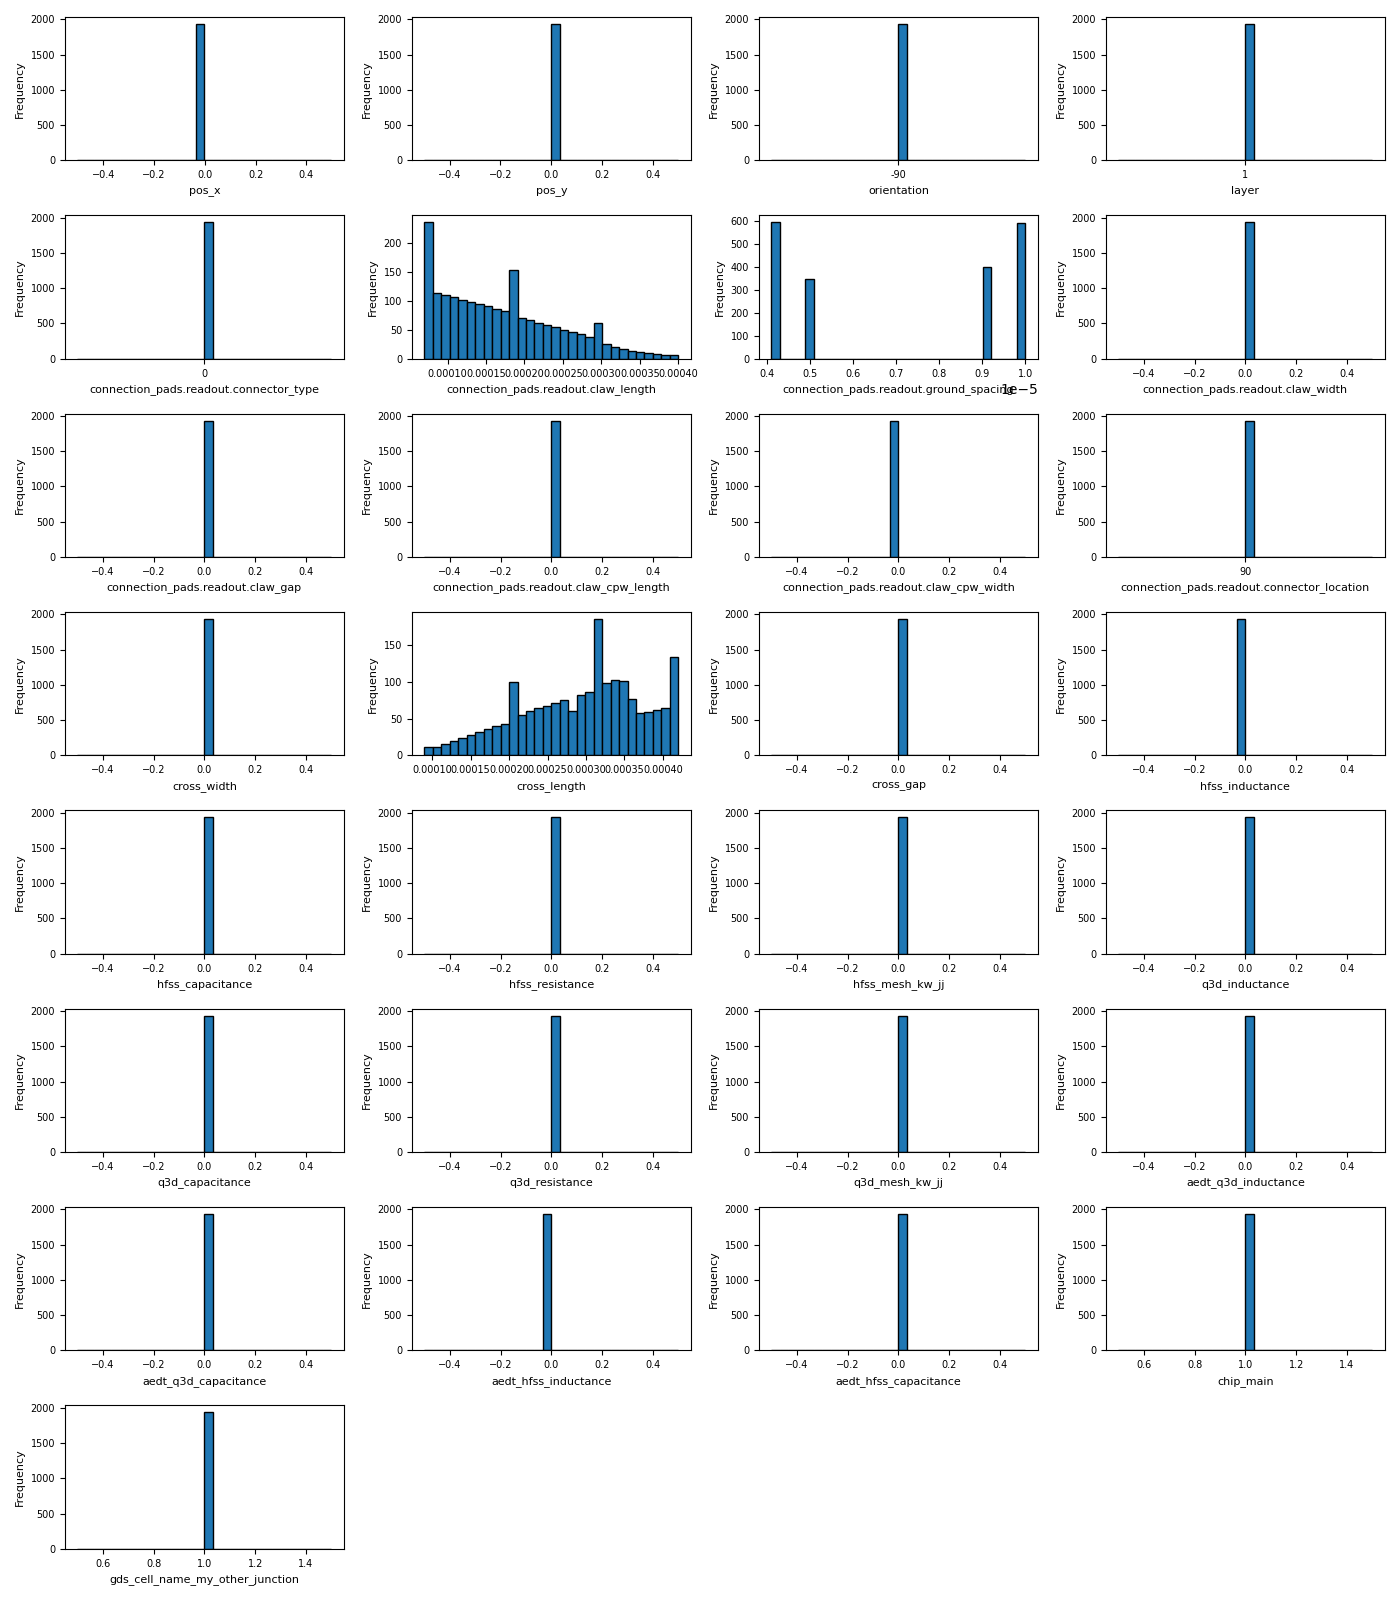

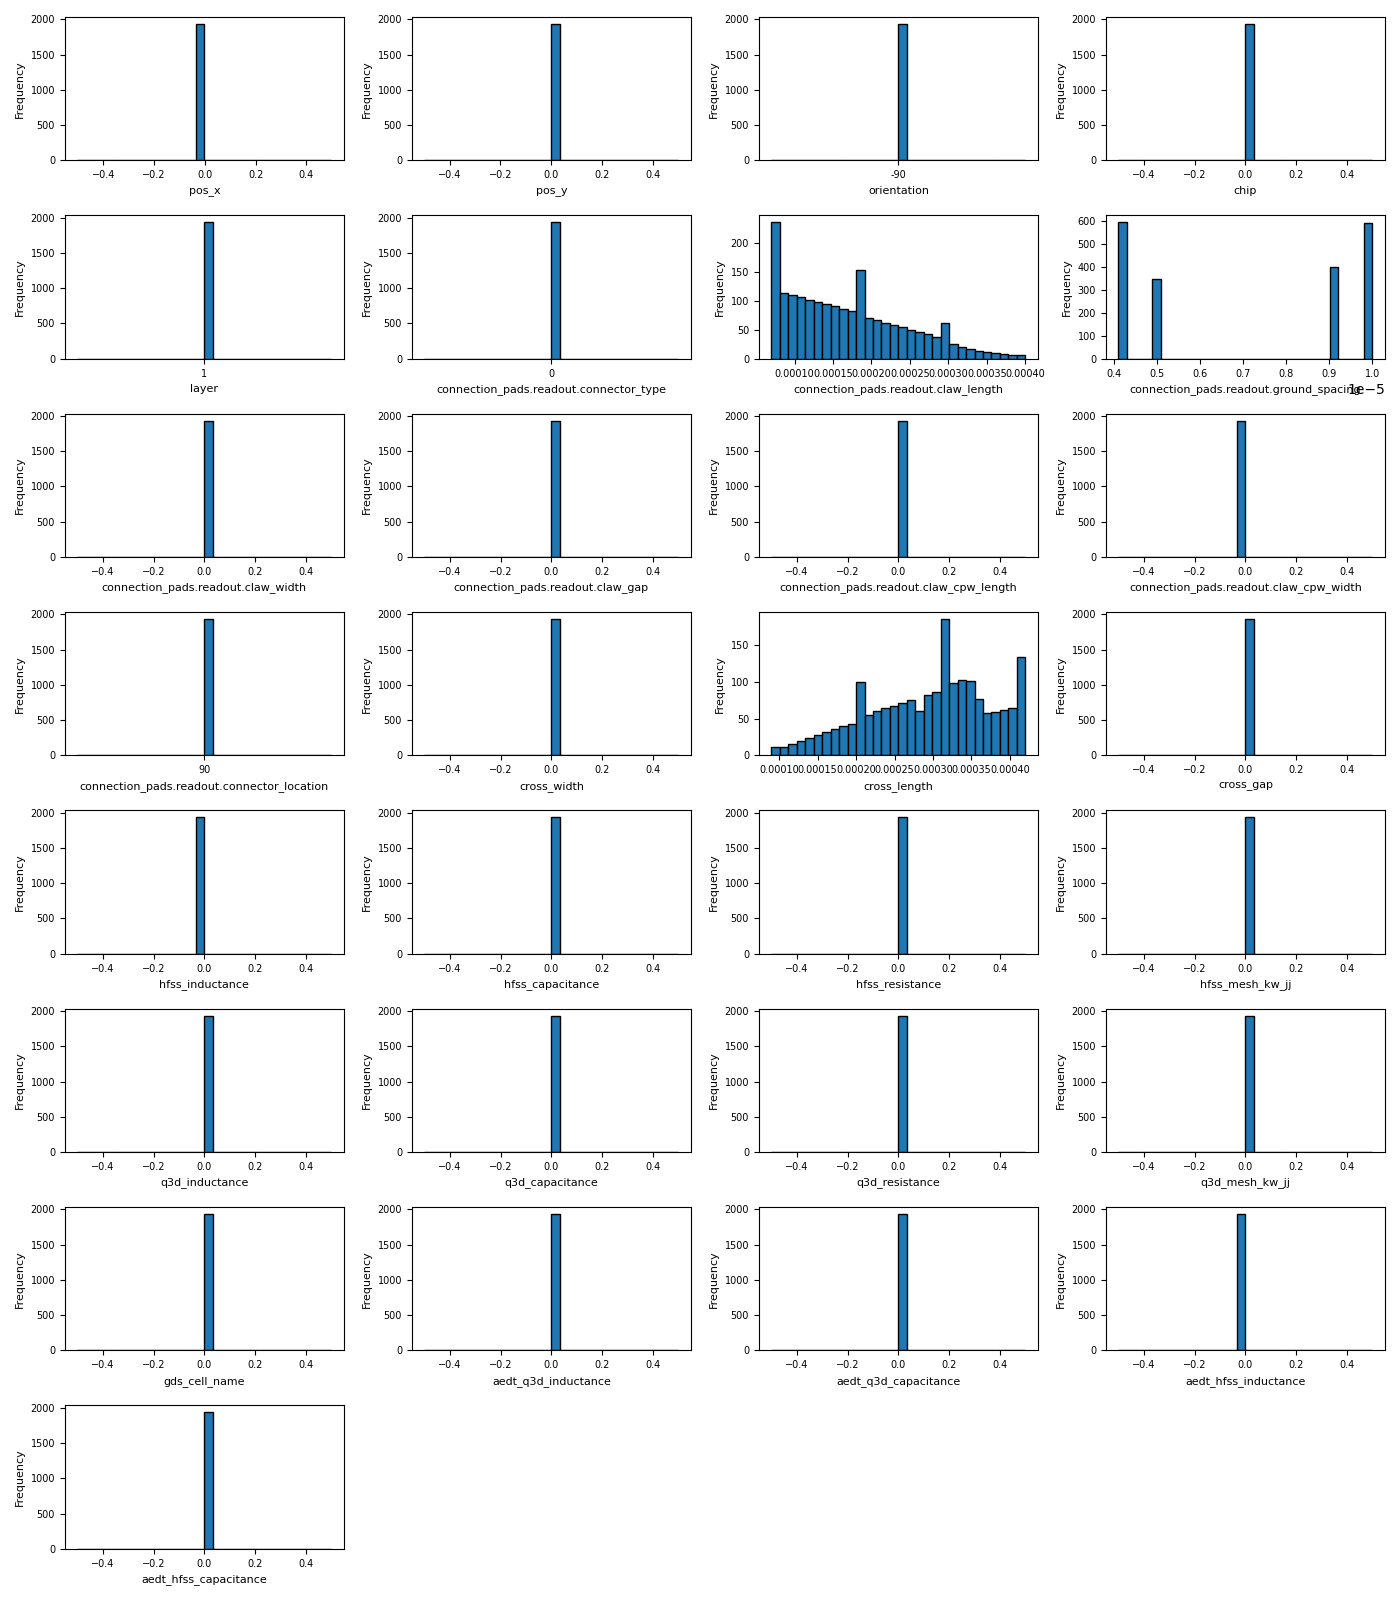

In [26]:
i=0
for y_encoding_format in y_encoding_formats:
    num_cols = len(y_encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_encoding_format[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

In [27]:
plt.close()

## Augment 

### Scale X

Scale kappa and frequency to be between 0 and 1

In [28]:
X_scaled = X.copy()
for col in X_scaled.columns:
    scaler = MinMaxScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]]) #only fit to this column
    joblib.dump(scaler, f'scalers/scaler_X_{col}.save') #save for later

In [29]:
# Check the scaling
display(X_scaled)

,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
0,0.623006,0.287003,0.158021,0.623006,0.278985,0.520187
1,0.780654,0.193600,0.099160,0.780654,0.185427,0.586467
2,0.336499,0.201503,0.115670,0.336499,0.195292,0.299301
3,0.706388,0.337883,0.309147,0.706388,0.341671,0.591782
4,0.419639,0.085508,0.094390,0.419639,0.084531,0.309166
...,...,...,...,...,...,...
1929,0.708108,0.372356,0.211509,0.708108,0.364515,0.607592
1930,0.776861,0.461131,0.470161,0.776861,0.474108,0.687075
1931,0.695820,0.651123,0.448546,0.695820,0.649208,0.702131
1932,0.084197,0.086269,0.065842,0.084197,0.083304,0.089659


### Scale y

In [30]:
y_scaled_encoding_formats = []

i=0
for y_encoding_format in y_encoding_formats:
    y_scaled = y_encoding_format.copy()
    for col in y_scaled.columns:
        scaler = MinMaxScaler()
        y_scaled[col] = scaler.fit_transform(y_scaled[[col]]) #only fit to this column
        joblib.dump(scaler, f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save') #save for later
    y_scaled_encoding_formats.append(y_scaled)
    i+=1

### Plot Scaled Data

### X

In [31]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X.columns):
    axes[i].hist(X[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/scaled_X_data.png')
plt.close()

### Y

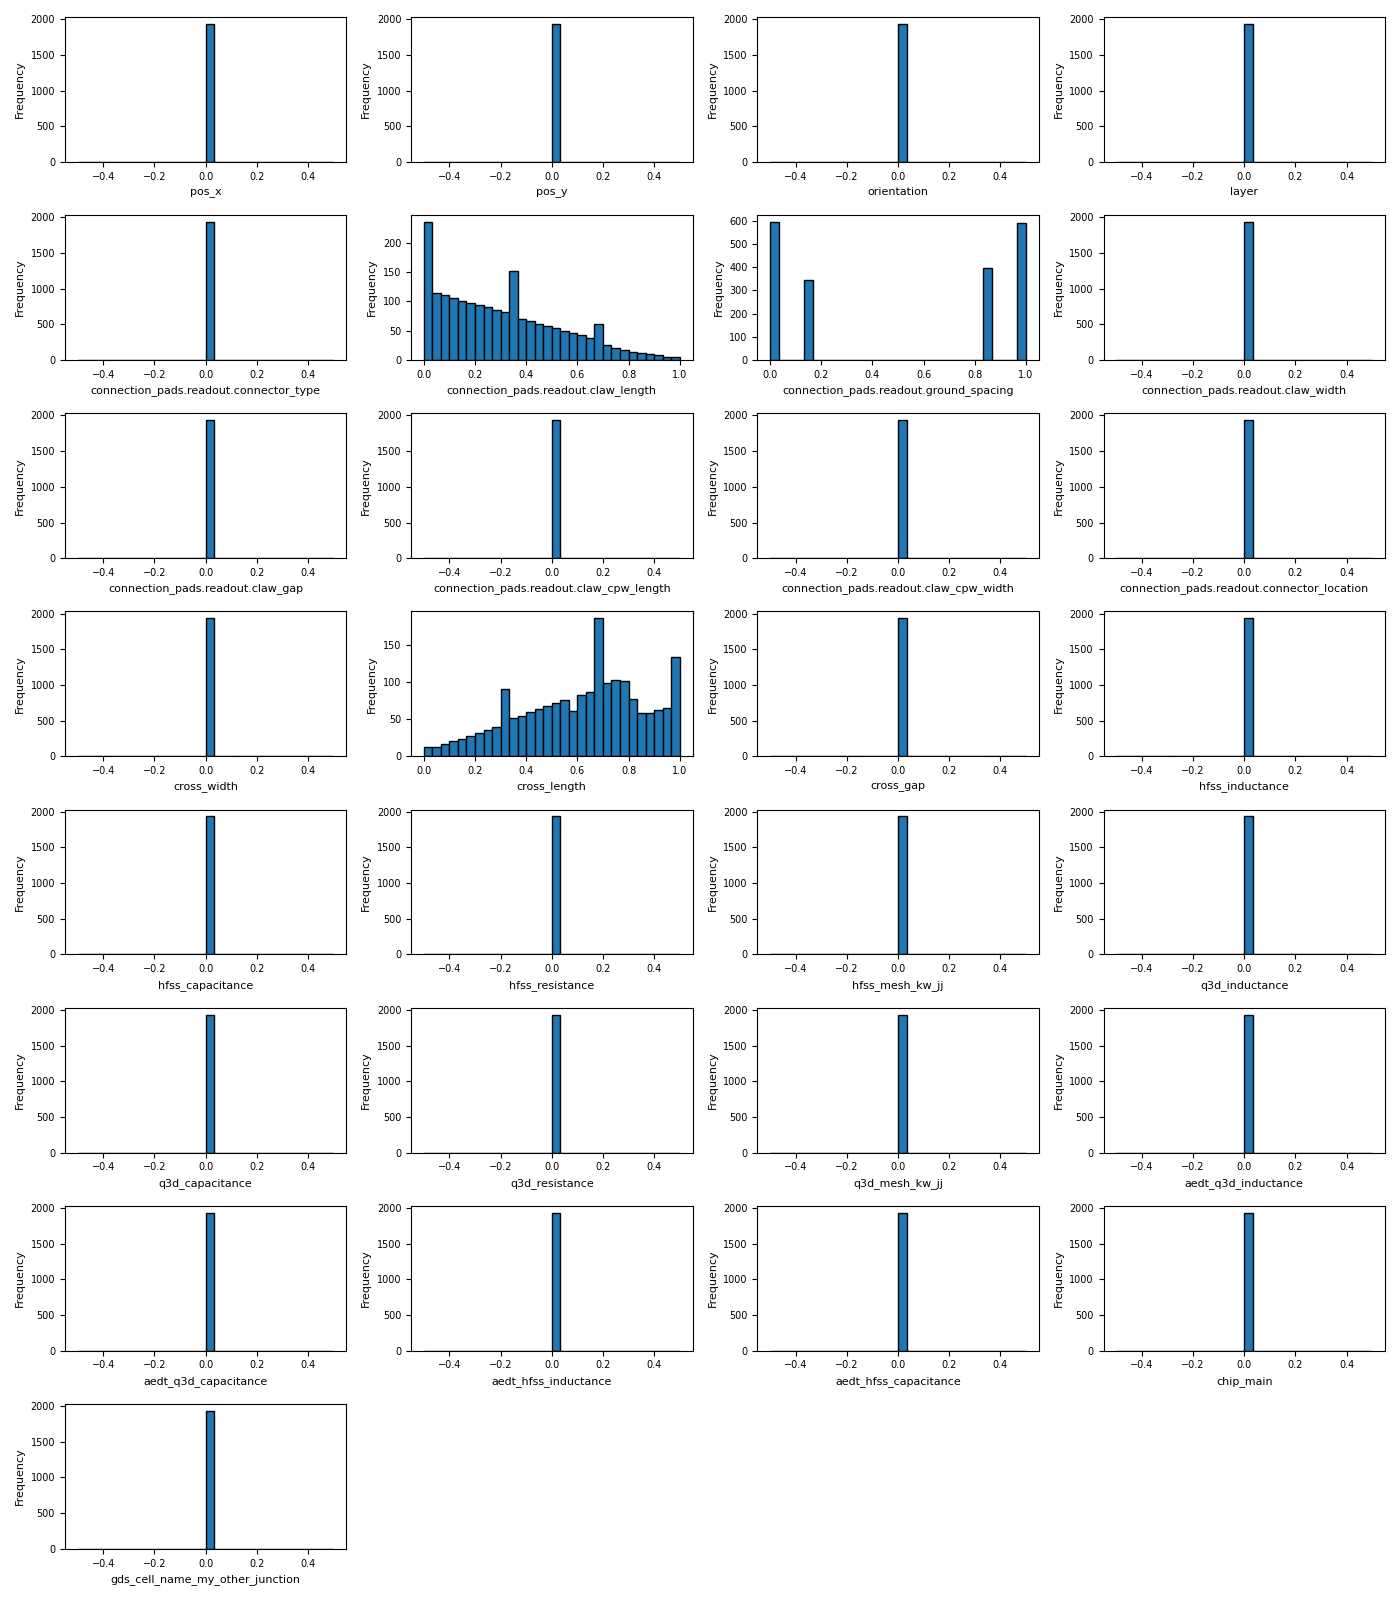

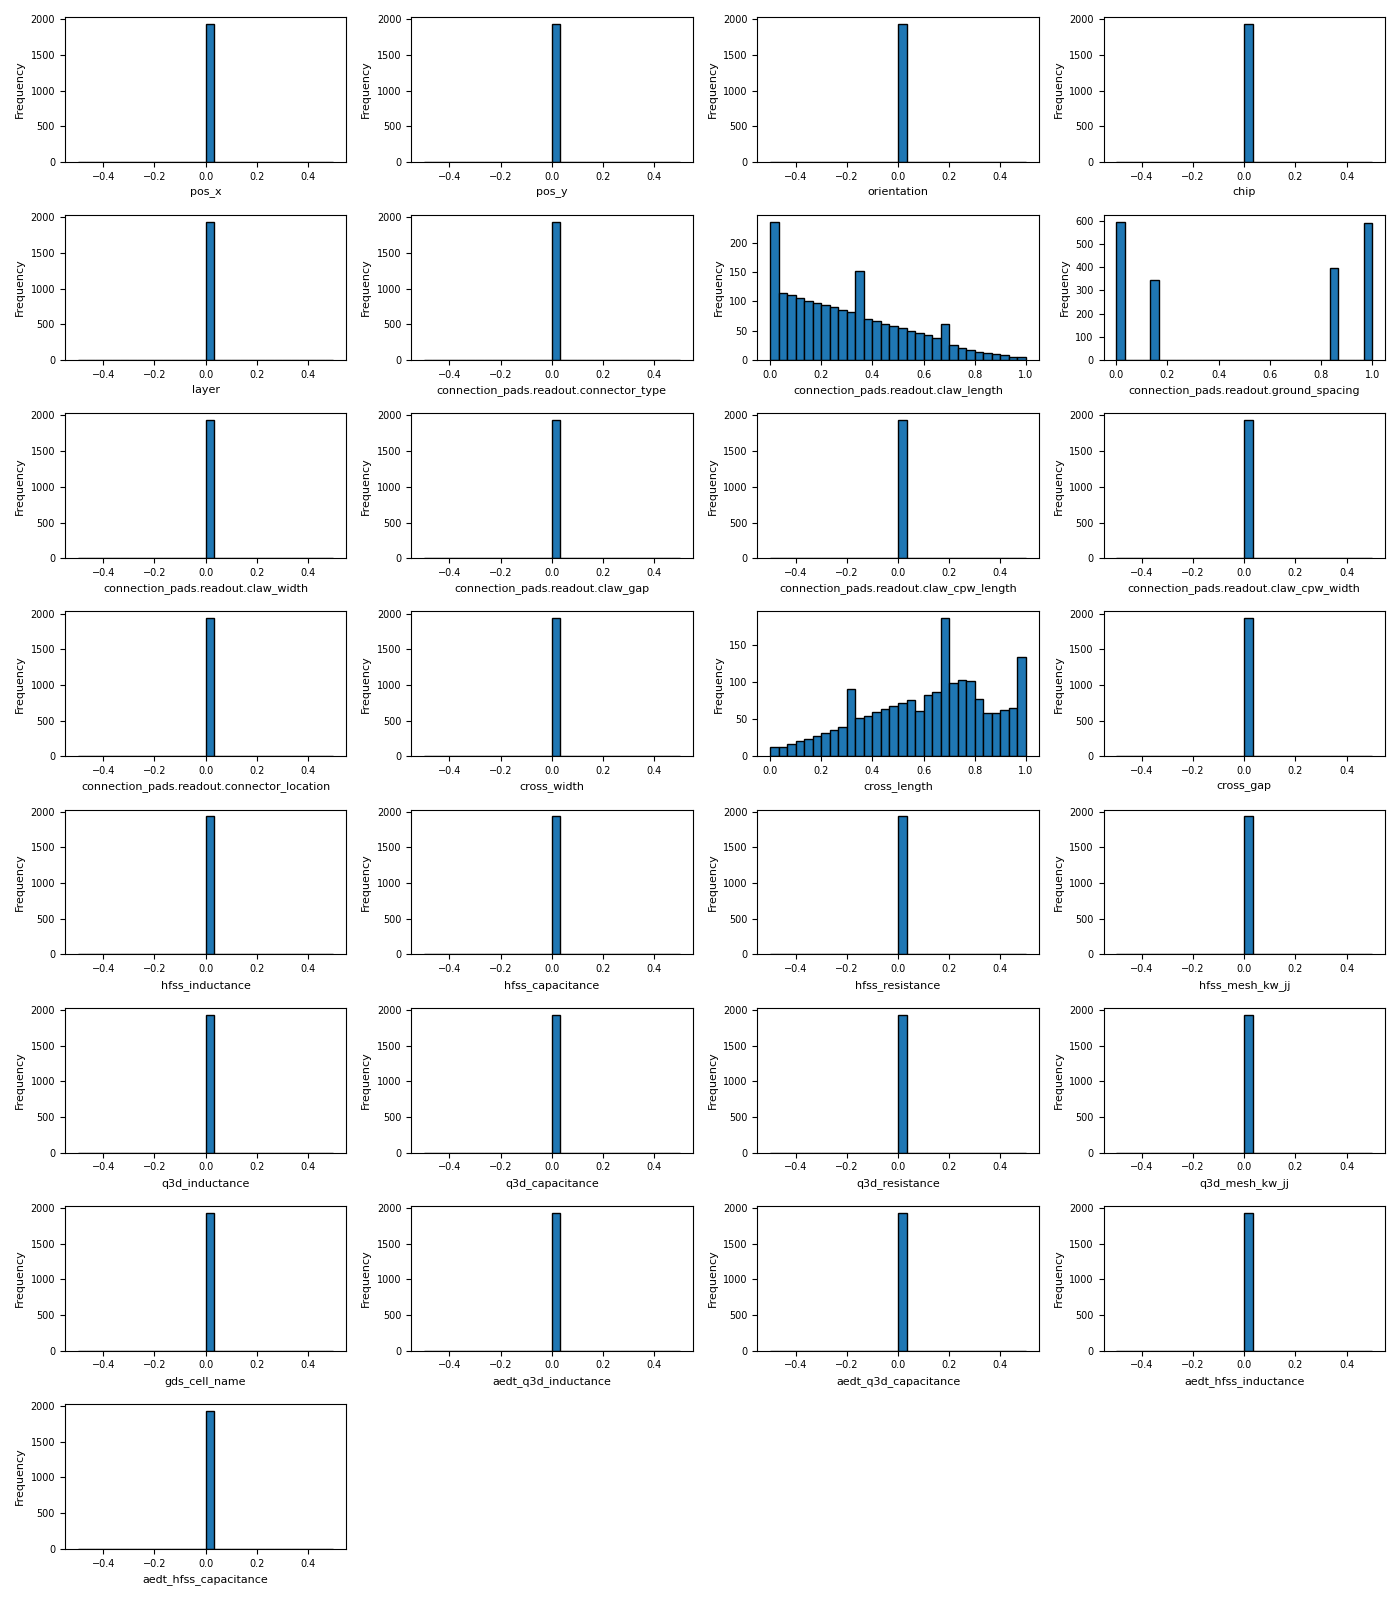

In [32]:
i=0
for y_scaled in y_scaled_encoding_formats:

    num_cols = len(y_scaled.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_scaled.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_scaled[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/scaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

In [33]:
plt.close()

### Unscale to make sure you can recreate original values with saved scaler

### 
Unscale X

In [34]:
X_orig = X_scaled.copy()
for col in X_scaled.columns:
    scaler = joblib.load(f'scalers/scaler_X_{col}.save')
    X_orig[col] = scaler.inverse_transform(X_scaled[[col]]) 

display(X_orig)

,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
0,158.40783,90.86585,3.73363,158.40783,94.97421,311.25590
1,188.15089,79.19378,2.93820,188.15089,82.44280,333.52997
2,104.35340,80.18130,3.16131,104.35340,83.76412,237.02548
3,174.13928,97.22405,5.77590,174.13928,103.37057,335.31609
4,120.03923,65.68607,2.87375,120.03923,68.92854,240.34085
...,...,...,...,...,...,...
1929,174.46380,101.53197,4.45645,174.46380,106.43025,340.62919
1930,187.43537,112.62570,7.95178,187.43537,121.10943,367.34003
1931,172.14561,136.36810,7.65968,172.14561,144.56289,372.39970
1932,56.75230,65.78116,2.48795,56.75230,68.76413,166.57383


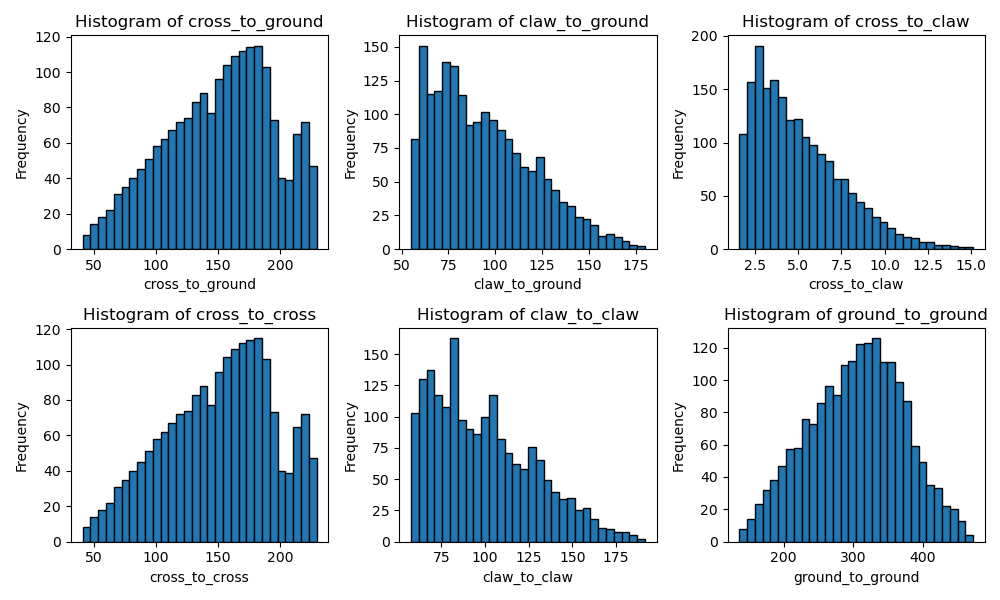

In [35]:
num_cols = len(X.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust 3 for the desired number of columns in subplot

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 3 * num_rows)) # Adjust figsize as needed

axes = axes.ravel() # Flatten the axes array for easier iteration

for i, column_header in enumerate(X_orig.columns):
    axes[i].hist(X_orig[column_header], bins=30, edgecolor='black')
    axes[i].set_title(f'Histogram of {column_header}')
    axes[i].set_xlabel(f'{column_header}')
    axes[i].set_ylabel('Frequency')


# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

### Unscale Y

In [36]:
y_orig_encoding_formats = []

i=0
for y_scaled in y_scaled_encoding_formats:
    y_orig = y_scaled.copy()
    for col in y_scaled.columns:
        scaler = joblib.load(f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save')
        y_orig[col] = scaler.inverse_transform(y_scaled[[col]])
    y_orig_encoding_formats.append(y_orig)
    print('Encoding Type: ', y_encoding_format_names[i])
    display(y_orig)
    print('\n')
    i+=1

Encoding Type:  one_hot


,design_options.pos_x,design_options.pos_y,design_options.orientation,design_options.layer,design_options.connection_pads.readout.connector_type,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.connection_pads.readout.claw_width,design_options.connection_pads.readout.claw_gap,design_options.connection_pads.readout.claw_cpw_length,...,design_options.q3d_inductance,design_options.q3d_capacitance,design_options.q3d_resistance,design_options.q3d_mesh_kw_jj,design_options.aedt_q3d_inductance,design_options.aedt_q3d_capacitance,design_options.aedt_hfss_inductance,design_options.aedt_hfss_capacitance,design_options.chip_main,design_options.gds_cell_name_my_other_junction
0,-0.0015,0.0012,-90.0,1.0,0.0,0.00016,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
1,-0.0015,0.0012,-90.0,1.0,0.0,0.00012,0.000009,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
2,-0.0015,0.0012,-90.0,1.0,0.0,0.00013,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
3,-0.0015,0.0012,-90.0,1.0,0.0,0.00018,0.000005,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
4,-0.0015,0.0012,-90.0,1.0,0.0,0.00009,0.000005,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,-0.0015,0.0012,-90.0,1.0,0.0,0.00019,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
1930,-0.0015,0.0012,-90.0,1.0,0.0,0.00024,0.000004,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
1931,-0.0015,0.0012,-90.0,1.0,0.0,0.00028,0.000009,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0
1932,-0.0015,0.0012,-90.0,1.0,0.0,0.00009,0.000010,0.000015,0.000005,0.00004,...,1.000000e-08,0.0,0.0,0.000007,1.000000e-08,0.0,9.686000e-09,0.0,1.0,1.0




Encoding Type:  linear


,design_options.pos_x,design_options.pos_y,design_options.orientation,design_options.chip,design_options.layer,design_options.connection_pads.readout.connector_type,design_options.connection_pads.readout.claw_length,design_options.connection_pads.readout.ground_spacing,design_options.connection_pads.readout.claw_width,design_options.connection_pads.readout.claw_gap,...,design_options.hfss_mesh_kw_jj,design_options.q3d_inductance,design_options.q3d_capacitance,design_options.q3d_resistance,design_options.q3d_mesh_kw_jj,design_options.gds_cell_name,design_options.aedt_q3d_inductance,design_options.aedt_q3d_capacitance,design_options.aedt_hfss_inductance,design_options.aedt_hfss_capacitance
0,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00016,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
1,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00012,0.000009,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
2,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00013,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
3,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00018,0.000005,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
4,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00009,0.000005,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00019,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
1930,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00024,0.000004,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
1931,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00028,0.000009,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0
1932,-0.0015,0.0012,-90.0,0.0,1.0,0.0,0.00009,0.000010,0.000015,0.000005,...,0.000007,1.000000e-08,0.0,0.0,0.000007,0.0,1.000000e-08,0.0,9.686000e-09,0.0


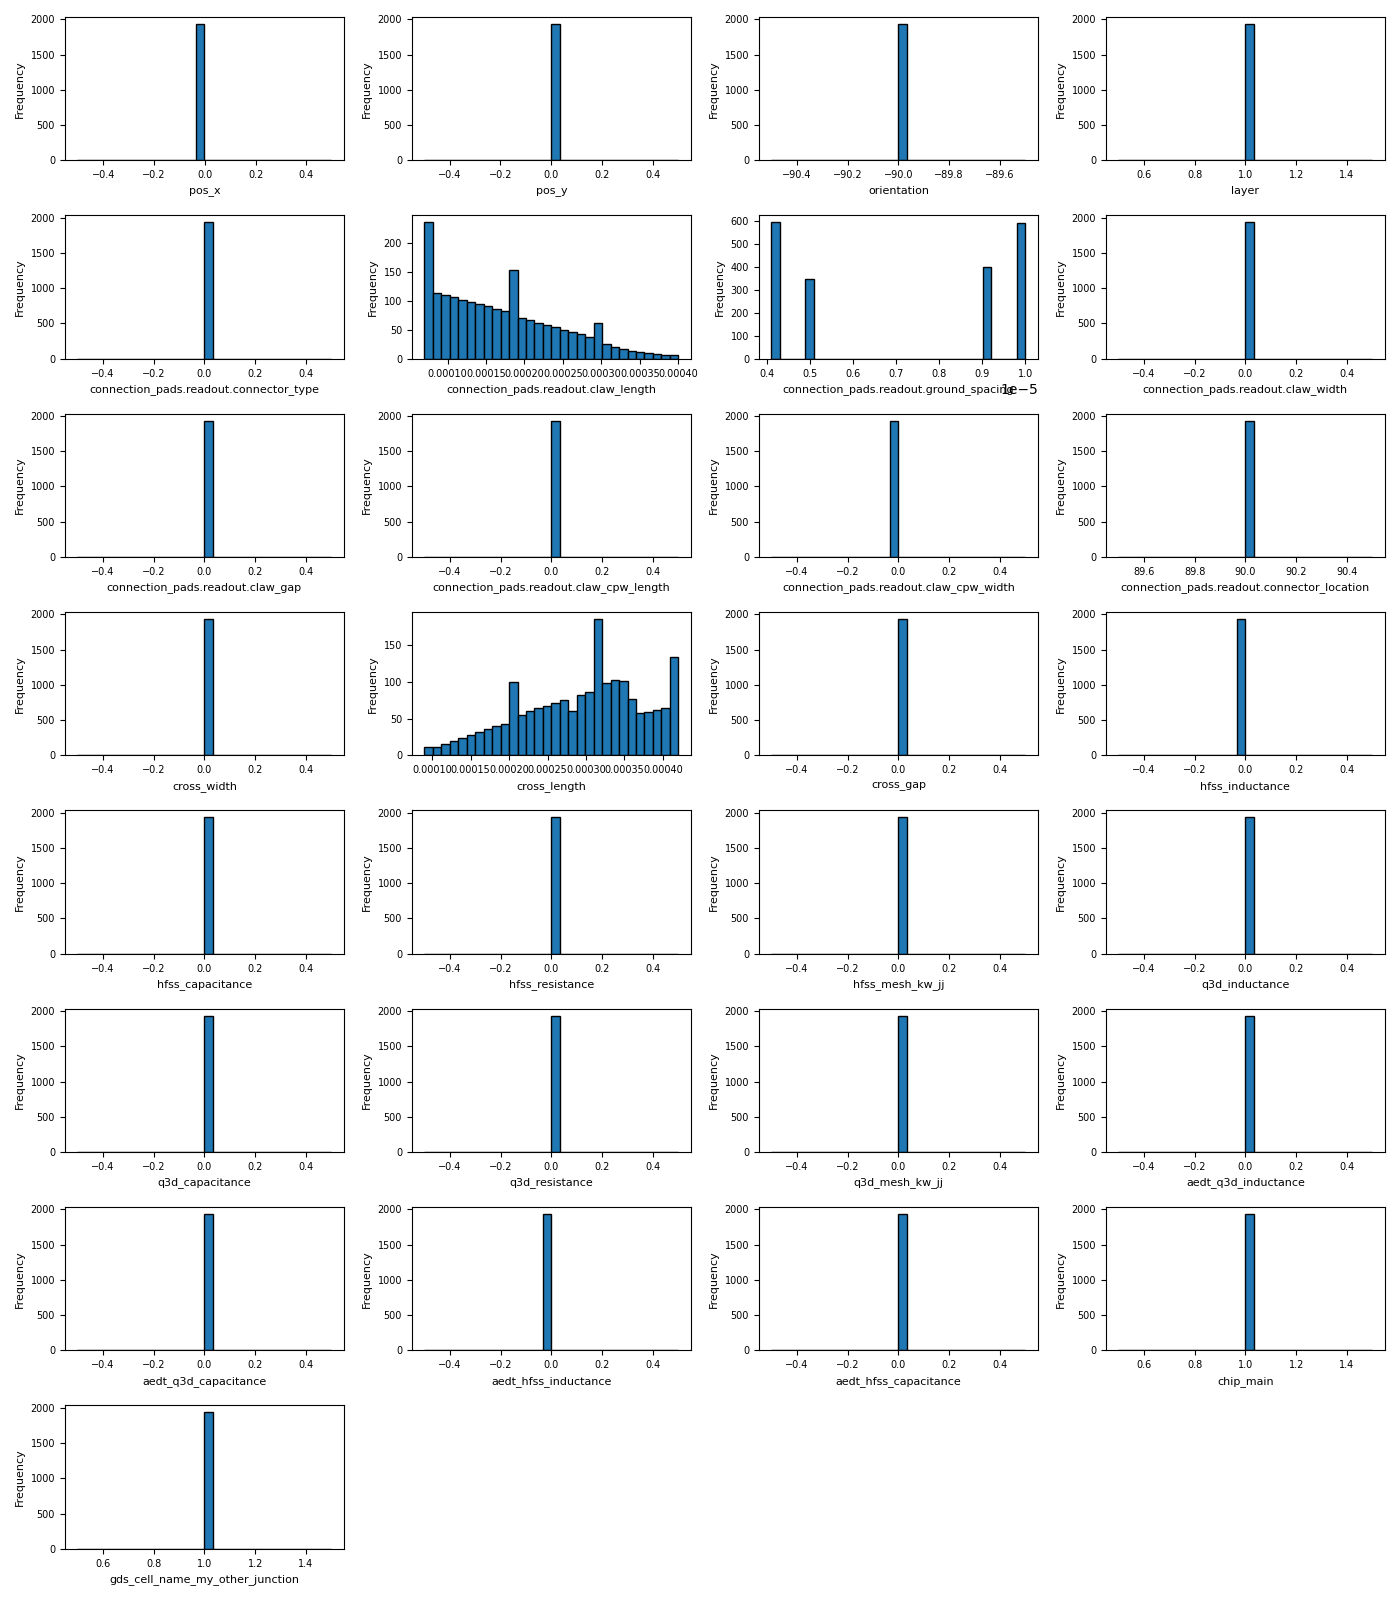

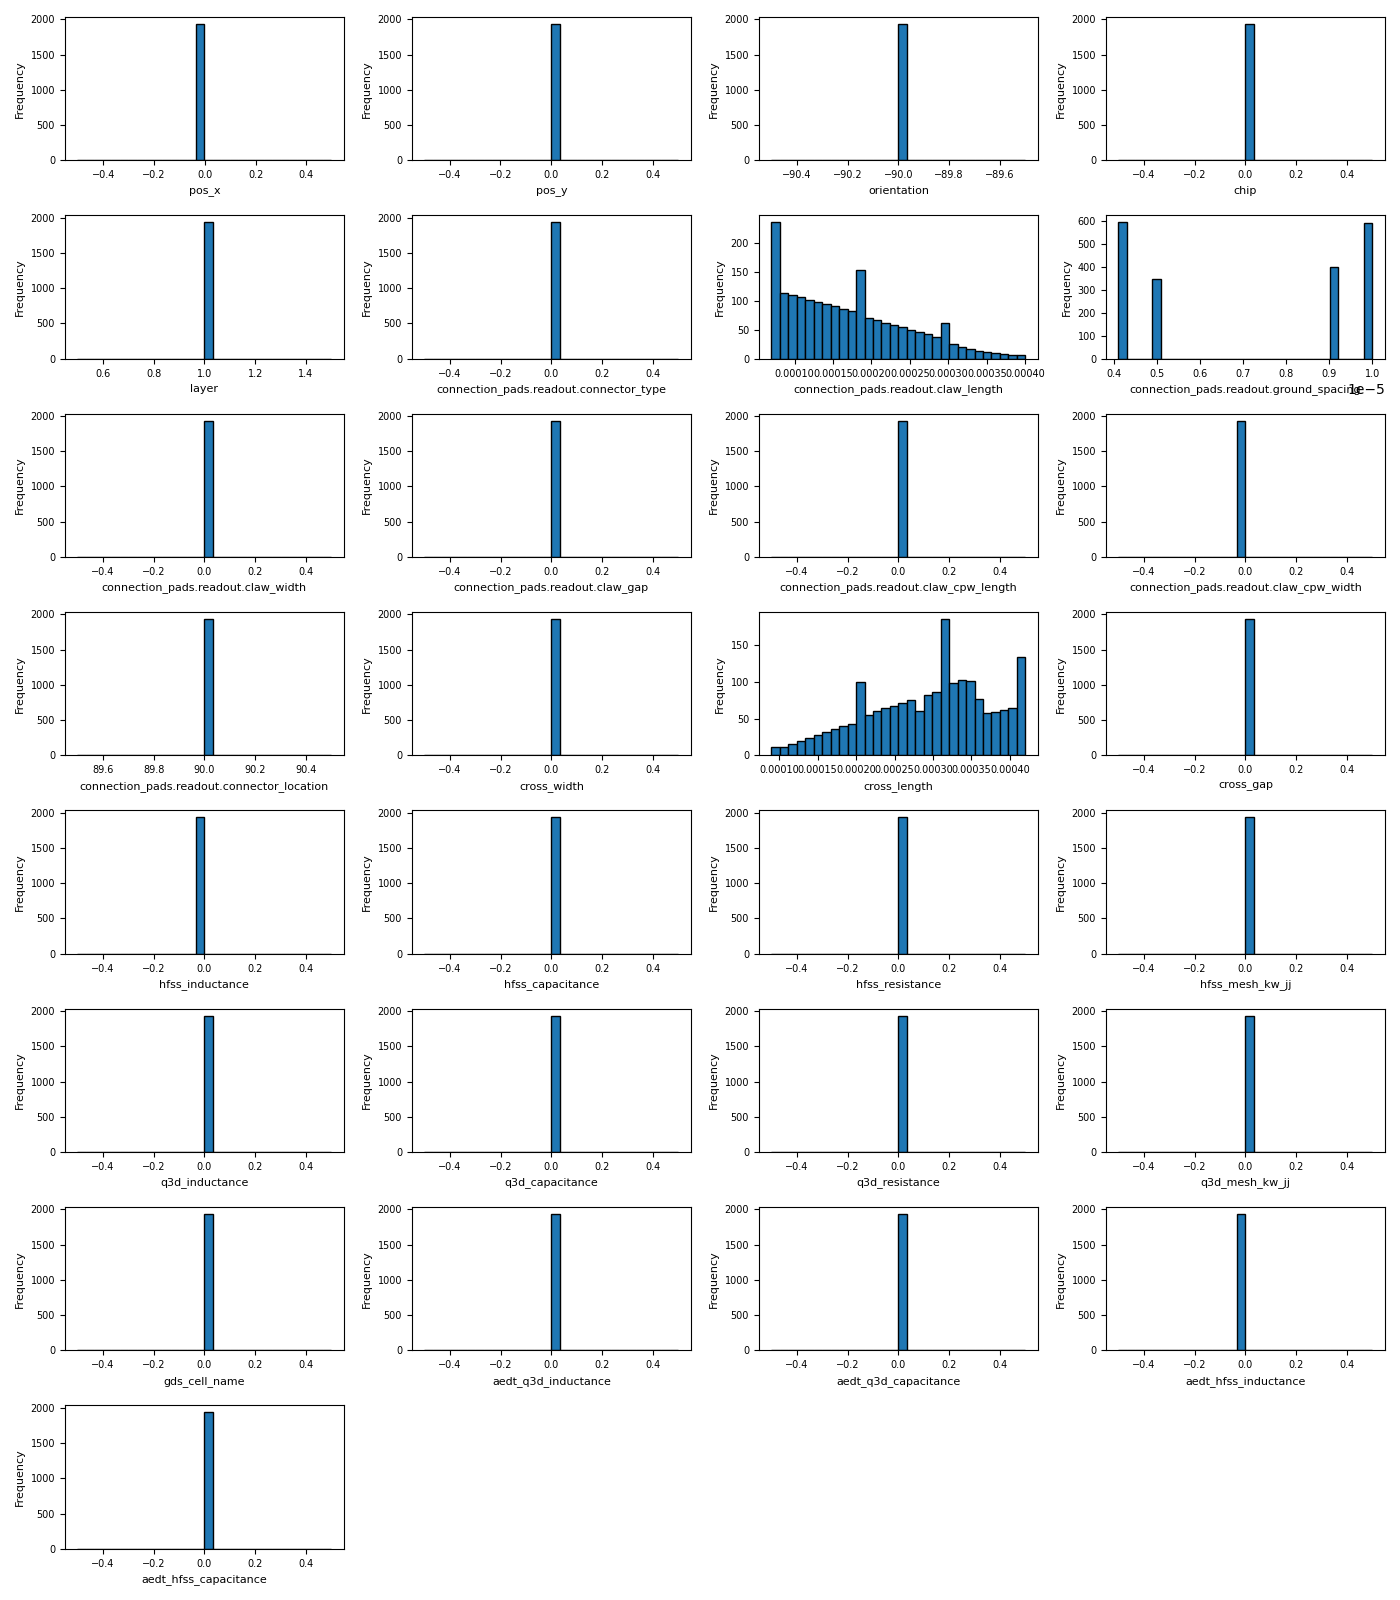

In [37]:
i=0
for y_orig in y_orig_encoding_formats:
    num_cols = len(y_orig.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for i, col in enumerate(y_orig.columns):
        try:
            plt.subplot(num_rows, 4, i + 1)
            plt.hist(y_orig[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.show()
    i+=1

## Split

In [38]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

2025-08-07 20:05:35.379673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-07 20:05:35.379765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-07 20:05:35.381489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-07 20:05:35.388266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow ver. 2.16.2


Dataset split is 80%-20% training-validation and test sets. We use a constant state (seed) for reproducible splits across multiple runs.

In [39]:
# Unscaled data split
if 'One Hot' in ENCODING_TYPE:
    X_train, X_val_test, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val, X_test, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train, X_val_test, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val, X_test, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )
elif 'Try Both' in ENCODING_TYPE:
    X_train_one_hot_encoding, X_val_test_one_hot_encoding, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_one_hot_encoding, X_test_one_hot_encoding, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test_one_hot_encoding, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    )
    X_train_linear_encoding, X_val_test_linear_encoding, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_linear_encoding, X_test_linear_encoding, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test_linear_encoding, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )

# Scaled data split
if 'One Hot' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_linear_hot_encoding, y_val_test_linear_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test
elif 'Try Both' in ENCODING_TYPE:
    X_train_scaled_one_hot_encoding, X_val_test_scaled_one_hot_encoding, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_one_hot_encoding, X_test_scaled_one_hot_encoding, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

    X_train_scaled_linear_encoding, X_val_test_scaled_linear_encoding, y_train_scaled_linear_encoding, y_val_test_scaled_linear_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_linear_encoding, X_test_scaled_linear_encoding, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled_linear_encoding, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test


In [40]:
#unscaled
if 'One Hot' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (1353, 29), 69.96%
Validation one-hot encoding set shape: (290, 29), 14.99%
Test set shape:                 (291, 29), 15.05%
---------------------------------------
---------------------------------------
Train linear encoding set shape: (1353, 29), 69.96%
Validation linear encoding set shape: (290, 29), 14.99%
Test set shape:                 (291, 29), 15.05%
---------------------------------------


In [41]:
#scaled
if 'One Hot' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (1353, 29), 69.96%
Validation one-hot encoding set shape: (290, 29), 14.99%
Test set shape:                 (291, 29), 15.05%
---------------------------------------
---------------------------------------
Train linear encoding set shape: (1353, 29), 69.96%
Validation linear encoding set shape: (290, 29), 14.99%
Test set shape:                 (291, 29), 15.05%
---------------------------------------


In [42]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train_scaled) #can check this in next script as well after loading to make sure it matches
    display(X_val_scaled)
else:
    display(X_train_scaled_one_hot_encoding) 
    display(X_val_scaled_one_hot_encoding)
    
    display(X_train_scaled_linear_encoding) 
    display(X_val_scaled_linear_encoding)

,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
745,0.797065,0.167811,0.186224,0.797065,0.170497,0.590252
1442,0.935571,0.112346,0.035722,0.935571,0.102415,0.654904
937,0.572617,0.077568,0.030243,0.572617,0.070155,0.406528
493,0.783325,0.135930,0.062109,0.783325,0.127677,0.566596
1271,0.302181,0.026974,0.054122,0.302181,0.025535,0.210652
...,...,...,...,...,...,...
1130,0.899724,0.107100,0.122690,0.899724,0.106805,0.631712
1294,0.678909,0.424576,0.263333,0.678909,0.418264,0.606124
860,0.865190,0.603335,0.603027,0.865190,0.620070,0.795719
1459,0.121036,0.161510,0.134773,0.121036,0.160606,0.141011


,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
1856,0.592406,0.536415,0.590114,0.592406,0.556627,0.594784
832,0.648160,0.665161,0.687053,0.648160,0.687163,0.676029
1393,0.632044,0.165660,0.082761,0.632044,0.157998,0.477859
483,0.388943,0.083663,0.096217,0.388943,0.082879,0.288633
1023,0.486161,0.404871,0.451805,0.486161,0.419695,0.475693
...,...,...,...,...,...,...
999,0.739732,0.396096,0.238704,0.739732,0.389678,0.633312
637,1.000000,0.052912,0.004411,1.000000,0.043784,0.677131
1113,0.677632,0.592444,0.629032,0.677632,0.613631,0.669884
1704,0.642828,0.509973,0.333563,0.642828,0.505496,0.613830


,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
745,0.797065,0.167811,0.186224,0.797065,0.170497,0.590252
1442,0.935571,0.112346,0.035722,0.935571,0.102415,0.654904
937,0.572617,0.077568,0.030243,0.572617,0.070155,0.406528
493,0.783325,0.135930,0.062109,0.783325,0.127677,0.566596
1271,0.302181,0.026974,0.054122,0.302181,0.025535,0.210652
...,...,...,...,...,...,...
1130,0.899724,0.107100,0.122690,0.899724,0.106805,0.631712
1294,0.678909,0.424576,0.263333,0.678909,0.418264,0.606124
860,0.865190,0.603335,0.603027,0.865190,0.620070,0.795719
1459,0.121036,0.161510,0.134773,0.121036,0.160606,0.141011


,cross_to_ground,claw_to_ground,cross_to_claw,cross_to_cross,claw_to_claw,ground_to_ground
1856,0.592406,0.536415,0.590114,0.592406,0.556627,0.594784
832,0.648160,0.665161,0.687053,0.648160,0.687163,0.676029
1393,0.632044,0.165660,0.082761,0.632044,0.157998,0.477859
483,0.388943,0.083663,0.096217,0.388943,0.082879,0.288633
1023,0.486161,0.404871,0.451805,0.486161,0.419695,0.475693
...,...,...,...,...,...,...
999,0.739732,0.396096,0.238704,0.739732,0.389678,0.633312
637,1.000000,0.052912,0.004411,1.000000,0.043784,0.677131
1113,0.677632,0.592444,0.629032,0.677632,0.613631,0.669884
1704,0.642828,0.509973,0.333563,0.642828,0.505496,0.613830


### Save

Save the split data set for future reference

In [43]:
!rm -f $DATA_DIR/npy/*npy

In [44]:
#unscaled
if 'One Hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test.npy'.format(DATA_DIR), X_test)
    
    np.save('{}/npy/y_train.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test.npy'.format(DATA_DIR), y_test_one_hot_encoding)
elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test.npy'.format(DATA_DIR), X_test)
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), y_test_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [45]:
#scaled
if 'One Hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)

elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding) 
    np.save('{}/npy/y_val_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)

elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [46]:
!ls $DATA_DIR/npy/*npy

data/npy/x_test_linear_encoding_augmented.npy
data/npy/x_test_linear_encoding.npy
data/npy/x_test_one_hot_encoding_augmented.npy
data/npy/x_test_one_hot_encoding.npy
data/npy/x_train_linear_encoding_augmented.npy
data/npy/x_train_linear_encoding.npy
data/npy/x_train_one_hot_encoding_augmented.npy
data/npy/x_train_one_hot_encoding.npy
data/npy/x_val_linear_encoding_augmented.npy
data/npy/x_val_linear_encoding.npy
data/npy/x_val_one_hot_encoding_augmented.npy
data/npy/x_val_one_hot_encoding.npy
data/npy/y_test_linear_encoding_augmented.npy
data/npy/y_test_linear_encoding.npy
data/npy/y_test_one_hot_encoding_augmented.npy
data/npy/y_test_one_hot_encoding.npy
data/npy/y_train_linear_encoding_augmented.npy
data/npy/y_train_linear_encoding.npy
data/npy/y_train_one_hot_encoding_augmented.npy
data/npy/y_train_one_hot_encoding.npy
data/npy/y_val_linear_encoding_augmented.npy
data/npy/y_val_linear_encoding.npy
data/npy/y_val_one_hot_encoding_augmented.npy
data/npy/y_val_one_hot_encoding.npy


In [47]:
with open('X_names', 'w') as f:
        f.write('\n'.join(X.columns))